# Tabular modelling

Since an embedding is just a look-up into an array, it can handle any kind of discrete categorical data. Embeddings therefore allow us to feed columns that contain categories into a model that expects continuous variables. 

The number of discrete levels of a categorical variable is called its _cardinality_. When you have high-cardinality categorical variables, deep learning approaches can often beat the next-best thing, which is usually gradient-boosted decision trees.

## Bluebook sales competition

The [bluebook datset](https://www.kaggle.com/c/bluebook-for-bulldozers) is a kaggle competition, involving prediction of the auction sale price for a piece of bulldozers. 

In [1]:
from kaggle import api
from fastai.tabular.all import *
from dtreeviz.trees import *

In [2]:
path = URLs.path('bluebook')
path

Path('/home/jupyter/.fastai/archive/bluebook')

In [3]:
Path.BASE_PATH = path

In [7]:
if not path.exists():
    path.mkdir()
    api.competition_download_cli('bluebook-for-bulldozers', path=path)
    file_extract(path/'bluebook-for-bulldozers.zip')

In [9]:
path.ls()

(#15) [Path('bluebook-for-bulldozers.zip'),Path('Test.csv'),Path('Train.zip'),Path('median_benchmark.csv'),Path('Valid.zip'),Path('Machine_Appendix.csv'),Path('Valid.7z'),Path('Data Dictionary.xlsx'),Path('Train.7z'),Path('TrainAndValid.7z')...]

In [10]:
path.ls(file_type='text')

(#7) [Path('Test.csv'),Path('median_benchmark.csv'),Path('Machine_Appendix.csv'),Path('ValidSolution.csv'),Path('Valid.csv'),Path('random_forest_benchmark_test.csv'),Path('TrainAndValid.csv')]

The competition says that the key fields are in `train.csv`, which are:

- SalesID: the unique identifier of the sale
- MachineID: the unique identifier of a machine.  A machine can be sold multiple times
- saleprice: what the machine sold for at auction (only provided in train.csv)
- saledate: the date of the sale


In [11]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

(Generally it's good specify `low_memory=False` unless Pandas actually runs out of memory and returns an error because the `low_memory` parameter, which is `True` by default, tells Pandas to only look at a few rows of data at a time to figure out the data type of each column.)

In [13]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

That's a lot of columns to understand!

It's a good idea to sort out **ordinal** columns, meaning discrete/ordered. For instance, `ProductSize`:

In [14]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large',
       'Compact'], dtype=object)

We can tell Pandas about a suitable ordering of levels as follows

In [15]:
sizes = 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact'

In [16]:
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

In [17]:
df['ProductSize']

0            NaN
1         Medium
2            NaN
3          Small
4            NaN
           ...  
412693      Mini
412694      Mini
412695      Mini
412696      Mini
412697      Mini
Name: ProductSize, Length: 412698, dtype: category
Categories (6, object): ['Large' < 'Large / Medium' < 'Medium' < 'Small' < 'Mini' < 'Compact']

`SalePrice` is the dependent variable we are trying to predict.

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices. So take the log of `SalePrice`:

In [18]:
dep_var = 'SalePrice'

In [19]:
df[dep_var] = np.log(df[dep_var])

### Handling of dates

If we're going to take advantage of dates, we can use fastai's `add_datepart` which generates additional columns using the date. This is an example of **feature engineering**.

In [22]:
df = add_datepart(df, 'saledate')

In [23]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

Let's do the same for the test set while we're at it

In [24]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

### Using `TabularPandas` and `TabularProc` in fastai

Out of the box, sklearn can't handle strings or missing data. `TabularPandas` wraps a Pandas DataFrame and provides a few convenience methods.

To populate a `TabularPandas` we'll use two `TabularProc`s: `Categorify` and `FillMissing`.

- `Categorify`: Replaces a column witha numeric categorical column
- `FillMissing`: Replaces missing values with the median of the column, and creates a new Boolean column that is `True` for any row where the value was missing.

A `TabularProc` is like a regular `Transform` except it does the transformations in-place, and when the data are first passed in (rather than lazily as data is accessed), to save memory and time.

In [26]:
procs = [Categorify, FillMissing]

`TabularPandas` will also partition into train/valid.

The test set in this competition is 2 weeks after the final training date. We should do something similar for our train/valid split.

In [38]:
np.sort(df.saleYear.unique())

array([1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
       2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012])

In [46]:
df[df['saleYear']>=2011][['saleYear', 'saleMonth']].drop_duplicates().sort_values(by=['saleYear', 'saleMonth'])

,saleYear,saleMonth
749,2011,1
52,2011,2
697,2011,3
66,2011,4
3,2011,5
35,2011,6
197,2011,7
287,2011,8
9996,2011,9
22915,2011,10


In [47]:
cond = (df.saleYear<2011) | (df.saleMonth<10)

In [49]:
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]

In [50]:
splits = (list(train_idx), list(valid_idx))

`TabularPandas` needs to be told which columns are continuous and which are categorical. We can handle that by using the helper function `cont_cat_split`:

In [61]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

In [62]:
L(cont)

(#12) ['SalesID','MachineID','ModelID','datasource','auctioneerID','YearMade','MachineHoursCurrentMeter','saleYear','saleMonth','saleDay'...]

In [63]:
L(cat)

(#52) ['UsageBand','fiModelDesc','fiBaseModel','fiSecondaryDesc','fiModelSeries','fiModelDescriptor','ProductSize','fiProductClassDesc','state','ProductGroup'...]

In [67]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

A `TabularPandas` behaves much like a fastai `Datasets` object, including `train` and `valid` attributes

In [68]:
len(to.train), len(to.valid)

(404710, 7988)

The data is still displayed as strings for categories

In [69]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleWeek,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,46,False,False,False,False,False,False,1163635200,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,16,3,320,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,13,False,False,False,False,False,False,1080259200,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,26,4,86,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,9,False,False,False,False,False,False,1077753600,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,26,3,57,9.210340


But the underlying items are all numeric

In [70]:
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,963,...,320,1,1,1,1,1,1,2647,1,1
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,1745,...,86,1,1,1,1,1,1,2148,1,1
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,1,336,...,57,1,1,1,1,1,1,2131,1,1


The `.classes` attribute is essentially a `vocab` for tabular data

In [72]:
to.classes['ProductSize']

(#7) ['#na#','Large','Large / Medium','Medium','Small','Mini','Compact']

In [73]:
(path/'to.pkl').save(to)

## Decision trees

We'll start with decision trees for our modelling.

In [76]:
from sklearn.tree import DecisionTreeRegressor

In [74]:
to = (path/'to.pkl').load()

In [75]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

Now that the data are all numeric, and there are no missing values, we can create a decision tree

In [77]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

If I could get `graphviz` to work, I would draw the tree here.

In [82]:
# draw_tree(m, xs, size=7, leaves_parallel=True, precision=2)

To get something like this

<img src="./figures/tree.png" style="width:500px"> 

We can show the same information using dtreeviz

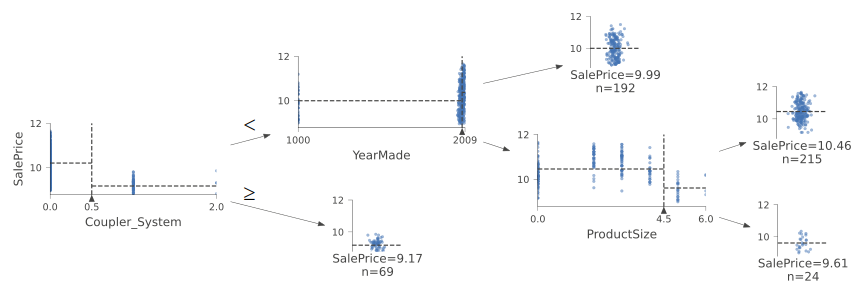

In [84]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

`YearMade` seems to have a missing value code of 1000

In [85]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

Note that the above won't change the result of the model, since decision trees only care about ranks in the independent variables

In [86]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

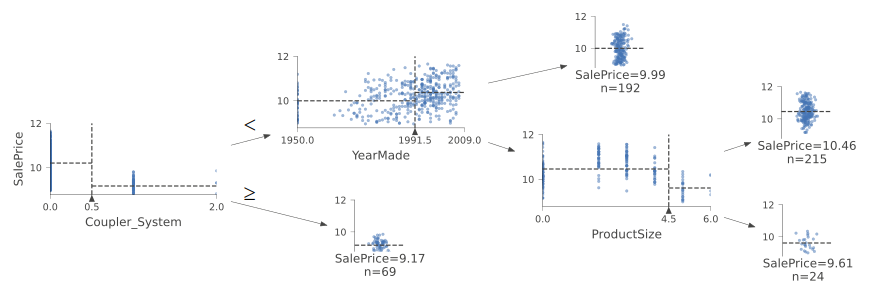

In [87]:
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

Let's build a deeper tree

In [88]:
m = DecisionTreeRegressor()
m.fit(xs, y);

In [92]:
def r_mse(pred, y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [93]:
m_rmse(m, xs, y)

0.0

So the training error is 0

In [94]:
m_rmse(m, valid_xs, valid_y)

0.33359

But the validation error isn't -- so we're probably overfitting quite badly

In [95]:
m.get_n_leaves(), len(xs)

(324558, 404710)

so we have almost 1 leaf per datapoint -- which pretty much the most overfit you can have in a model.

In [96]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.248593, 0.323406)

In [97]:
m.get_n_leaves()

12397

Which is a bit more reasonable.

## Random Forests

Have the following steps:

1. Randomly choose a subset of the rows of your data. (Also choose a subset of the columns, this is called the "random subspace" method).
1. Train a model using this subset.
1. Save that model, and then return to step 1 a few times.
1. This will give you a number of trained models. To make a prediction, predict using all of the models, and then take the average of each of those model's predictions.

This is a procedure called "bagging" or "bootstrap aggregating". The errors between these models are uncorrelated because they each use random subsets of the data (and features), hence taking an aggregate of these weak learners can give more accurate results.


In [99]:
from sklearn.ensemble import RandomForestRegressor

In [100]:
n_estimators=40  # number of trees to train
max_samples=200_000  # number of rows to use for each model (about half the data)
max_features=0.5  # number of features to use for each model
min_samples_leaf=5  # stopping criterion for each model

m = RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True)
m.fit(xs, y);

In [101]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.171029, 0.233427)

This is substantially better than a single, deep, tree

The nice thing about random forests is how robust it is to overfitting -- you can add lots of estimators, and because each learner is so weak, you won't really overfit.

To get at the underlying trees, we can use `m.estimators_`. We can get the predictions from each individual tree:

In [106]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [109]:
r_mse(preds.mean(0), valid_y)

0.233427

We can see how the validation error reduces with the number of learners. 

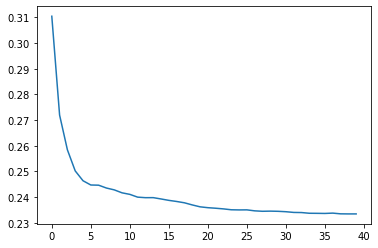

In [110]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

The performance really flattens after around 30 trees

The performance on our validation set is worse than on our training set. But is that because we're overfitting, or because the validation set covers a different time period, or a bit of both?

## Out-of-Bag error